<a href="https://colab.research.google.com/github/czarodziejszyn/ssne/blob/main/projekt2/predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:
import torch
import torch.nn as nn
import pandas as pd
import torch.utils.data as data
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'Subset'

In [3]:
class PredictorBN(nn.Module):
    def __init__(self):
        super(PredictorBN, self).__init__()
        self.lin1 =nn.Linear(23, 142)
        self.bn1 = nn.BatchNorm1d(142)
        self.act1 =nn.ReLU()
        self.lin2 =nn.Linear(142, 71)
        self.bn2 = nn.BatchNorm1d(71)
        self.act2 =nn.ReLU()
        self.lin3 =nn.Linear(71, 1)


    def forward(self, x):
        x = self.lin1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.lin2(x)
        x = self.bn2(x)
        x = self.act2(x)
        x = self.lin3(x)
        return x

In [5]:
train_data = pd.read_csv('train_data.csv')

In [6]:
num_cols = ['SalePrice', 'YearBuilt', 'Size(sqf)', 'Floor',
            'N_Parkinglot(Ground)', 'N_Parkinglot(Basement)', 'N_manager',
            'N_elevators', 'N_FacilitiesNearBy(Total)', 'N_SchoolNearBy(Total)']
cat_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'TimeToBusStop',
            'TimeToSubway', 'SubwayStation']

le = LabelEncoder()
train_data['TimeToBusStop'] = le.fit_transform(train_data['TimeToBusStop'])
train_data['TimeToSubway'] = le.fit_transform(train_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
train_data = pd.get_dummies(train_data, columns=ohe_cols, drop_first=True).astype(float)

In [ ]:
print(train_data.head())

To jest do nauczenia modelu z podziałem train test

In [15]:
train_dataset = data.TensorDataset(torch.tensor(train_data.drop('SalePrice', axis=1).values).float(),
                                   torch.tensor(train_data['SalePrice'].values).float())

train_indices, test_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, random_state=42)
train_dataset = data.Subset(train_dataset, train_indices)
test_dataset = data.Subset(train_dataset, test_indices)

data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

To jest do nauczenia modelu przed ostateczną predykcją

In [7]:
train_dataset = data.TensorDataset(torch.tensor(train_data.drop('SalePrice', axis=1).values).float(),
                                   torch.tensor(train_data['SalePrice'].values).float())
data_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)

In [8]:
model = PredictorBN()
criterion = nn.MSELoss()
opt_bn = torch.optim.Adam(model.parameters(), lr=0.001)

Epoch: 0, Loss: 9395955712.0
Epoch: 1, Loss: 8907320320.0
Epoch: 2, Loss: 9955725312.0
Epoch: 3, Loss: 28594665472.0
Epoch: 4, Loss: 21716957184.0
Epoch: 5, Loss: 13451917312.0
Epoch: 6, Loss: 15633092608.0
Epoch: 7, Loss: 12520270848.0
Epoch: 8, Loss: 13509560320.0
Epoch: 9, Loss: 16756457472.0
Epoch: 10, Loss: 3320068864.0
Epoch: 11, Loss: 12184862720.0
Epoch: 12, Loss: 16161306624.0
Epoch: 13, Loss: 9661027328.0
Epoch: 14, Loss: 4698927104.0
Epoch: 15, Loss: 1619726336.0
Epoch: 16, Loss: 3464792832.0
Epoch: 17, Loss: 15940579328.0
Epoch: 18, Loss: 9045602304.0
Epoch: 19, Loss: 6017083904.0
Epoch: 20, Loss: 6338381312.0
Epoch: 21, Loss: 9744894976.0
Epoch: 22, Loss: 7094123520.0
Epoch: 23, Loss: 13070256128.0
Epoch: 24, Loss: 7544690688.0
Epoch: 25, Loss: 22732953600.0
Epoch: 26, Loss: 12101559296.0
Epoch: 27, Loss: 647865792.0
Epoch: 28, Loss: 27287967744.0
Epoch: 29, Loss: 1215537024.0
Epoch: 30, Loss: 1779712512.0
Epoch: 31, Loss: 17486770176.0
Epoch: 32, Loss: 8965681152.0
Epoch:

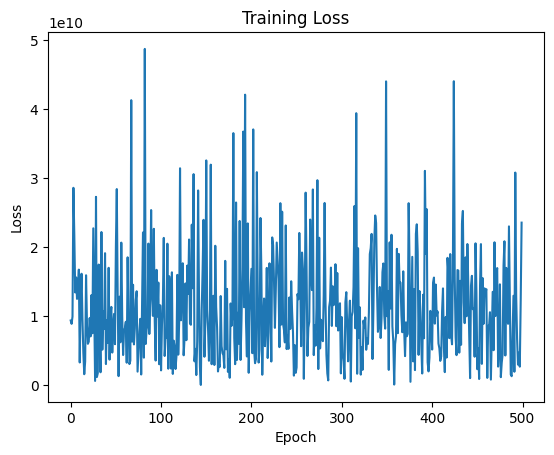

In [19]:
losses = []
for epoch in range(500):
  for x, y in data_loader:
    opt_bn.zero_grad()
    y_pred = model(x)
    loss = criterion(y_pred, y)
    loss.backward()
    opt_bn.step()
  losses.append(loss.item())
  print(f"Epoch: {epoch}, Loss: {loss.item()}")

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


Dane testowe

In [10]:
test_data = pd.read_csv('test_data.csv')

le = LabelEncoder()
test_data['TimeToBusStop'] = le.fit_transform(test_data['TimeToBusStop'])
test_data['TimeToSubway'] = le.fit_transform(test_data['TimeToSubway'])

ohe_cols = ['HallwayType', 'HeatingType', 'AptManageType', 'SubwayStation']
test_data = pd.get_dummies(test_data, columns=ohe_cols, drop_first=True).astype(float)

Model bez uczenia do walidowania

In [20]:
model.eval()
with torch.no_grad():
  y_pred_list = []
  y_true_list = []
  for x, y in data_loader:
    y_pred = model(x)
    y_pred_list.extend(y_pred.numpy().flatten().tolist())
    y_true_list.extend(y.numpy().flatten().tolist())

def assign_interval(value):
  if value <= 100000:
    return 0
  elif value <= 350000:
    return 1
  else:
    return 2

y_pred_intervals = [assign_interval(pred) for pred in y_pred_list]
y_true_intervals = [assign_interval(true) for true in y_true_list]

correct_predictions = sum([1 for i in range(len(y_pred_intervals)) if y_pred_intervals[i] == y_true_intervals[i]])
accuracy = (correct_predictions / len(y_pred_intervals)) * 100

print(f"Classification accuracy: {accuracy:.2f}%")

Classification accuracy: 72.69%
